In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split # Для деления данных
from sklearn.preprocessing import StandardScaler # Масштаб чисел
from sklearn.linear_model import Perceptron # Нейронка
from sklearn.neural_network import MLPClassifier # Нейронка
from sklearn.metrics import accuracy_score, classification_report # Оценка точности
from sklearn.model_selection import GridSearchCV # Поиск лучших параметров

%matplotlib inline

In [54]:
# Загружаем целевые метки, игноря заголовок
targets_data = pd.read_csv('Database/dataset/MovementAAL_target.csv', header=None)
# Ввод названия колонок вручную, так как заголовок игнорится
targets_df.columns = ['sequence_ID', 'class_label']

# Посмотрим на первые строки, чтобы убедиться, что все загрузилось правильно
print("Первые 5 строк targets_df:")
print(targets_df.head())
print(f"\nРазмер targets_df: {targets_df.shape}")

# Списки для данных и меток
X_list = []  # Сюда складывается признак для каждой последовательности
y_list = []  # Сюда соответствующие метки

# Счетчики для отладки
success_count = 0
missing_files = []

# Проходим по всем строкам файла с метками
for index, row in targets_df.iterrows():
    seq_id = row['sequence_ID']
    label = row['class_label']
    
    # Путь к файлам с данными
    file_path = f'Database/dataset/MovementAAL_RSS_{seq_id}.csv'
    
    # Существует ли файл
    if os.path.exists(file_path):
        # Загрузка CSV-файла, пропускаем строку с заголовком
        df = pd.read_csv(file_path, comment='#', header=None)
        # Названия колонок, так как заголовок с комментом
        df.columns = ['RSS_anchor1', 'RSS_anchor2', 'RSS_anchor3', 'RSS_anchor4']
        
        # Структуру данных для первой последовательности
        if seq_id == 1:
            print(f"Количество измерений: {len(df)}")
            print(f"Первые 5 строк:")
            print(df.head())
        
        # Представления последовательности
        # 1. Усреднение. Берётся среднее по каждому из 4 якорей.
        sequence_features = df.mean().values
        
        # 2. Стандартное отклонение для учета изменчивости сигнала.
        sequence_std = df.std().values
        
        # Объединение всех (средних и стандартных) отклонений
        sequence_features = np.concatenate([sequence_features, sequence_std])
        
        # Добавление признаков и меток в списки
        X_list.append(sequence_features)
        y_list.append(label)
        success_count += 1
    else:
        missing_files.append(seq_id)

# Преобразуем списки в numpy массивы
X = np.array(X_list)
y = np.array(y_list)

print(f"\nРезультаты загрузки:")
print(f"Успешно загружено: {success_count} файлов из {len(targets_df)}")
print(f"Отсутствующие файлы: {missing_files}")
print(f"Форма массива признаков X: {X.shape}")
print(f"Форма массива меток y: {y.shape}")

# Распределение классов
unique, counts = np.unique(y, return_counts=True)
print(f"\nРаспределение классов:")
for cls, count in zip(unique, counts):
    print(f"Класс {cls}: {count} примеров ({count/len(y)*100:.1f}%)")

Первые 5 строк targets_df:
   sequence_ID  class_label
0            1            1
1            2            1
2            3            1
3            4            1
4            5            1

Размер targets_df: (314, 2)
Количество измерений: 27
Первые 5 строк:
   RSS_anchor1  RSS_anchor2  RSS_anchor3  RSS_anchor4
0     -0.90476        -0.48      0.28571         0.30
1     -0.57143        -0.32      0.14286         0.30
2     -0.38095        -0.28     -0.14286         0.35
3     -0.28571        -0.20     -0.47619         0.35
4     -0.14286        -0.20      0.14286        -0.20

Результаты загрузки:
Успешно загружено: 314 файлов из 314
Отсутствующие файлы: []
Форма массива признаков X: (314, 8)
Форма массива меток y: (314,)

Распределение классов:
Класс -1: 156 примеров (49.7%)
Класс 1: 158 примеров (50.3%)


In [55]:
# Разделение данных. 60% - обучение, 20% - валидация (для подбора параметров), 20% - финальный тест.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Обучающая выборка: {X_train.shape[0]} примеров")
print(f"Валидационная выборка: {X_val.shape[0]} примеров")
print(f"Тестовая выборка: {X_test.shape[0]} примеров")

Обучающая выборка: 188 примеров
Валидационная выборка: 63 примеров
Тестовая выборка: 63 примеров


In [56]:
# Создание объекта scaler и обучение его НА ОБУЧАЮЩЕЙ ВЫБОРКЕ!!!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Применение того же самого преобразования к валидационной и тестовой выборкам
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# !!!Нельзя использовать fit_transform на валидации и тесте, чтобы не было утечки данных

In [57]:
# Модель 1: Perceptron (Однослойный перцептрон)
perceptron = Perceptron(random_state=42)
perceptron.fit(X_train_scaled, y_train)

# Модель 2: MLPClassifier (Многослойный перцептрон)
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train_scaled, y_train)

# Проверяем точность на валидационной выборке
y_val_pred_perceptron = perceptron.predict(X_val_scaled)
y_val_pred_mlp = mlp.predict(X_val_scaled)

print("Точность Perceptron (по умолчанию) на валидации:", accuracy_score(y_val, y_val_pred_perceptron))
print("Точность MLP (по умолчанию) на валидации:", accuracy_score(y_val, y_val_pred_mlp))

Точность Perceptron (по умолчанию) на валидации: 0.6984126984126984
Точность MLP (по умолчанию) на валидации: 0.873015873015873


In [58]:
# Использование кросс-валидации на обучающей выборке
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)], # Нейронов в скрытом слое (чем выше, тем больше мощи, но риск переобучения)
    'activation': ['relu', 'tanh'], # Функции активации (relu - выпрямитель (быстрый), tanh - тангенс гиперболический (плавный) (остальные либо устарело (как logistic), либо неактуально для MLP (identity))
    'alpha': [0.0001, 0.001, 0.01], # штрафы за сложность (регуляризация) - чем меньше, тем стабильнее и медленнее, и наоборот, если больше, то модель проще и меньше переобучение
    'learning_rate_init': [0.001, 0.01], # Скорость обучения
    'max_iter': [2000]  # Итерации
}

grid_mlp = GridSearchCV(
    MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=10),
    param_grid_mlp, # Даём список всех настроек для перебора
    cv=5, # Проверка каждой настройки 5 раз на разных данных (надёжность) - 24 параметра = 120 обучений.
    scoring='accuracy', # Сравнение по точности
    n_jobs=-1
)

# Обучаем на обучающей выборке с кросс-валидацией
grid_mlp.fit(X_train_scaled, y_train)

print("Лучшие параметры для MLP:")
print(grid_mlp.best_params_)
print("Лучшая точность кросс-валидации:", grid_mlp.best_score_)

# Лучшая модель уже обучена на всех X_train_scaled
best_mlp = grid_mlp.best_estimator_

y_val_pred_best = best_mlp.predict(X_val_scaled)
print("Точность лучшей модели на валидации:", accuracy_score(y_val, y_val_pred_best))

Лучшие параметры для MLP:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 2000}
Лучшая точность кросс-валидации: 0.7129445234708393
Точность лучшей модели на валидации: 0.6984126984126984


In [59]:
param_grid_perceptron = {
    'alpha': [0.0001, 0.001, 0.01], # Штраф за сложность
    'eta0': [0.001, 0.01, 0.1], # Шаги при обучении (чем меньше, тем точнее и наоборот, грубее)
    'penalty': [None, 'l2', 'l1', 'elasticnet'] # None - без регуляризации (риск переобучения), l2 - штраф за большие веса, l1 - обнуляет неважные веса, elasticnet - комбинация l1 и l2.
}

grid_perceptron = GridSearchCV(Perceptron(random_state=42, max_iter=1000), 
                               param_grid_perceptron, cv=5, scoring='accuracy', n_jobs=-1) # 180 обучений
grid_perceptron.fit(X_train_scaled, y_train)

print("Лучшие параметры для Perceptron:")
print(grid_perceptron.best_params_)
print("Лучшая точность кросс-валидации:", grid_perceptron.best_score_)

# Оцениваем на валидационной выборке
y_val_pred_perceptron = grid_perceptron.best_estimator_.predict(X_val_scaled)
print("Точность на валидации:", accuracy_score(y_val, y_val_pred_perceptron))

# Лучшая модель уже обучена на X_train_scaled
best_perceptron = grid_perceptron.best_estimator_

# НЕ ПЕРЕОБУЧАТЬ СЕЙЧАС! Надо сохранить для финального теста
# X_train_val_scaled и y_train_val буду использовать только далее
# На сиде 42 вышло, что один нейрон (перцептрон) показал большую нестабильность. Ибо MLP более надёжен, а один нейрон чувствителен к конкретному разделению данных

Лучшие параметры для Perceptron:
{'alpha': 0.01, 'eta0': 0.1, 'penalty': 'l2'}
Лучшая точность кросс-валидации: 0.7339971550497866
Точность на валидации: 0.6190476190476191


In [60]:
# Переобучение лучших моделей на объединенных данных
print("Переобучение лучших моделей на объединенных train+val данных...")

# Объединяю данные тут
X_train_val_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.hstack([y_train, y_val])

# Переобучаю модели
best_mlp.fit(X_train_val_scaled, y_train_val)
best_perceptron.fit(X_train_val_scaled, y_train_val)

print(f"Размер объединенной обучающей выборки: {X_train_val_scaled.shape}")

Переобучение лучших моделей на объединенных train+val данных...
Размер объединенной обучающей выборки: (251, 8)


In [70]:
# Предсказание на отложенной тестовой выборке
y_test_pred_mlp = best_mlp.predict(X_test_scaled)
y_test_pred_perceptron = best_perceptron.predict(X_test_scaled)

# Финальная точность
final_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
final_accuracy_perceptron = accuracy_score(y_test, y_test_pred_perceptron)

print("="*50)
print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*50)
print(f"Точность лучшего MLP: {final_accuracy_mlp:.4f}")
print(f"Точность лучшего Perceptron: {final_accuracy_perceptron:.4f}")

# Детальный отчет по классификации
# print("\nДетальный отчет для MLP:")
# print(classification_report(y_test, y_test_pred_mlp))

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
Точность лучшего MLP: 0.8095
Точность лучшего Perceptron: 0.6032


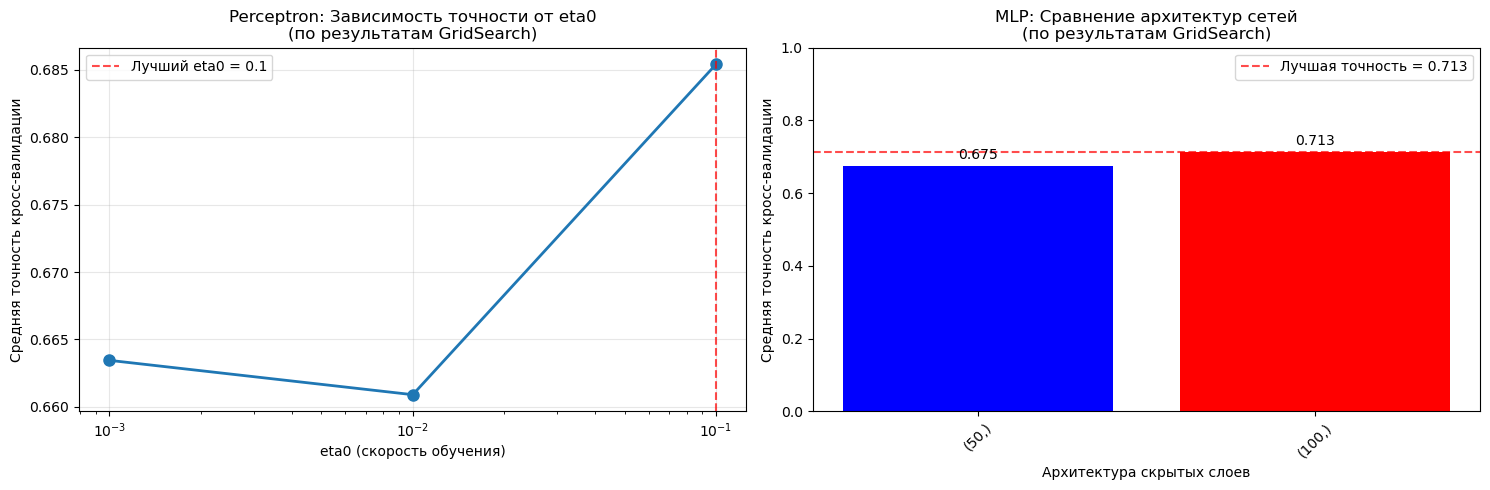

In [71]:
# Построение графиков на основе результатов
plt.figure(figsize=(15, 5))

# График 1: Анализ параметров Perceptron из GridSearch
plt.subplot(1, 2, 1)

# Анализ результатов GridSearch для Perceptron
perceptron_results = pd.DataFrame(grid_perceptron.cv_results_)

# Группировка по eta0 для графика
eta0_analysis = perceptron_results.groupby('param_eta0')['mean_test_score'].mean()

plt.plot(eta0_analysis.index.astype(float), eta0_analysis.values, 'o-', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('eta0 (скорость обучения)')
plt.ylabel('Средняя точность кросс-валидации')
plt.title('Perceptron: Зависимость точности от eta0\n(по результатам GridSearch)')
plt.grid(True, alpha=0.3)

# Отметка лучшиего параметра
best_eta0 = grid_perceptron.best_params_['eta0']
best_score = grid_perceptron.best_score_
plt.axvline(x=best_eta0, color='red', linestyle='--', alpha=0.7, label=f'Лучший eta0 = {best_eta0}')
plt.legend()

# График 2: Анализ архитектур MLP из GridSearch
plt.subplot(1, 2, 2)

# Анализ результатов GridSearch для MLP
mlp_results = pd.DataFrame(grid_mlp.cv_results_)

# Группировка по архитектуре скрытых слоев
architectures = []
scores = []

for idx, row in mlp_results.iterrows():
    arch = row['param_hidden_layer_sizes']
    score = row['mean_test_score']
    architectures.append(str(arch))
    scores.append(score)

# Уберу дубликаты (беру максимальную оценку для каждой архитектуры)
arch_dict = {}
for arch, score in zip(architectures, scores):
    if arch not in arch_dict or score > arch_dict[arch]:
        arch_dict[arch] = score

architectures = list(arch_dict.keys())
scores = list(arch_dict.values())

bars = plt.bar(architectures, scores, color=['blue', 'red'])
plt.xlabel('Архитектура скрытых слоев')
plt.ylabel('Средняя точность кросс-валидации')
plt.title('MLP: Сравнение архитектур сетей\n(по результатам GridSearch)')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Добавление значения на столбцы
for bar, acc in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# Отметка лучшей архитектуры
best_arch = str(grid_mlp.best_params_['hidden_layer_sizes'])
best_mlp_score = grid_mlp.best_score_
plt.axhline(y=best_mlp_score, color='red', linestyle='--', alpha=0.7, 
            label=f'Лучшая точность = {best_mlp_score:.3f}')
plt.legend()

plt.tight_layout()
plt.show()